# Feature-based mitotic classifier using gradient boosted decision trees

In [1]:
import os, sys, gc, itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.core.display import display

## Plotting and analysis functions

In [2]:
def modelAnalysis(test_y, predict):
    target_na = ["not mitotic", "M1: prophase 1", "M2: prophase 2", "M3: pro metaphase 1", 
                 "M4: pro metaphase 2", "M5: metaphase", "M6: anaphase", "M7: telophase-cytokinesis"]
        
    print(classification_report(test_y, predict, target_names=target_na))
    print('accuracy', accuracy_score(test_y, predict))
    mat = confusion_matrix(test_y, predict)
    
    target_na = np.array(target_na)
    plt.figure(figsize=(10,10))
    a = plot_confusion_matrix(mat, classes = target_na, normalize = False)
    plt.grid(b=False)
    plt.show()

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    temp = []
    mat = cm
    for i in range(len(mat)):
        temp.append((mat[i, :].astype(np.float64)/(sum(mat[i])+1e-32).tolist()))
    
    mat = np.array(temp)
    
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = sum(cm[i])/ 2.
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def make_X_y_from_df(dataframe, X_cols, y_col,
                     make_y_int=True, drop_bad_vals=True):
    
    dataframe = dataframe[[y_col, *X_cols]]
    
    if drop_bad_vals:
        dataframe = dataframe.dropna()
        dataframe = dataframe[dataframe[target_col] >= 0]

    y = dataframe[y_col]
    X = dataframe[X_cols].values
    
    if make_y_int:
        le = LabelEncoder()
        le.fit(y)
        y = le.transform(y)
    else:
        y = y.values
        
    return X,y

## use ZY's feats

### Load data

In [5]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

df = df.dropna(subset=['MitosisLabel'])

print('Release', df.query('MitoticHandoff == "Release"').shape)
print('Ongoing', df.query('MitoticHandoff == "Ongoing"').shape)
print('Microscopy', df.query('MitoticHandoff == "Microscopy"').shape)

df_release = df.query('MitoticHandoff == "Release"')
df_ongoing = df.query('MitoticHandoff == "Ongoing" | MitoticHandoff == "Microscopy"')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Release (4457, 2531)
Ongoing (2349, 2531)
Microscopy (323, 2531)


In [6]:
target_col = 'MitosisLabel'
feature_cols = ['feat_nuc_region_std_px',
                'feat_nuc_mt_edge_3',
                'feat_nuc_mt_edge_8',
                'feat_nuc_mt_edge_9',
                'feat_nuc_mt_edge_10',
                'feat_nuc_mt_edge_15',
                'feat_cell_obj_mean_depth',
                'feat_nuc_obj_tot_sphericity',
                'feat_nuc_obj_max_spherical_obj',
                'feat_nuc_obj_mean_spherical_obj']

### Train and test set -- use to find a good model

In [7]:
X_train_test, y_train_test = make_X_y_from_df(df_release,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_train_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([4207,   31,   22,   16,   39,   23,   27,   92]))

### Validation set -- held out until after model is locked down

In [8]:
X_validation, y_validation = make_X_y_from_df(df_ongoing,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_validation, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2324,   15,    8,   30,   59,   30,   44,  162]))

### Split train and test apart

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test,
                                                    test_size=0.2,
                                                    random_state=42)

unique_classes, class_counts = np.unique(y_train_test, return_counts=True)
class_weights = class_counts/np.sum(class_counts)
class_weights

lgb_train = lgb.Dataset(X_train, y_train,
                        weight=np.array([class_weights[int(i)] for i in y_train]),
                        free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train,
                        weight=np.array([class_weights[int(i)] for i in y_test]),
                       free_raw_data=False)

### Train the model

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(unique_classes),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 100
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_test,
                num_boost_round=1000,
                verbose_eval=100,
                early_stopping_rounds=5)

Training until validation scores don't improve for 5 rounds.
[100]	valid_0's multi_logloss: 0.571207
[200]	valid_0's multi_logloss: 0.202899
[300]	valid_0's multi_logloss: 0.0752054
[400]	valid_0's multi_logloss: 0.0295635
[500]	valid_0's multi_logloss: 0.013521
[600]	valid_0's multi_logloss: 0.00787893
[700]	valid_0's multi_logloss: 0.00629821
Early stopping, best iteration is:
[743]	valid_0's multi_logloss: 0.00594656


### Training performance on  old data

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

              not mitotic       0.99      1.00      0.99      3361
           M1: prophase 1       0.00      0.00      0.00        26
           M2: prophase 2       0.89      0.80      0.84        20
      M3: pro metaphase 1       1.00      0.55      0.71        11
      M4: pro metaphase 2       0.83      1.00      0.91        34
            M5: metaphase       1.00      0.65      0.79        17
             M6: anaphase       0.94      0.68      0.79        25
M7: telophase-cytokinesis       0.86      0.86      0.86        71

              avg / total       0.98      0.98      0.98      3565

accuracy 0.983450210379


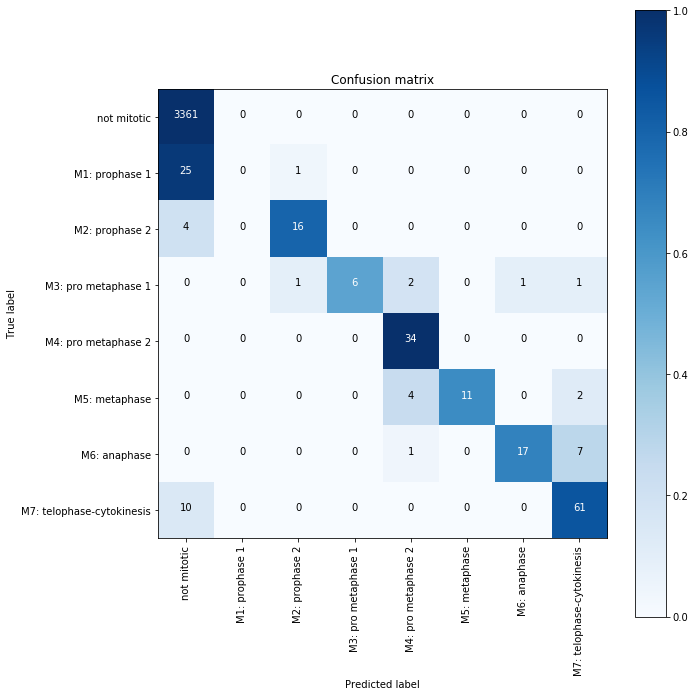

In [11]:
pred_classes_train = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_train)])
modelAnalysis(y_train, pred_classes_train)

### Testing performance on old data

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

              not mitotic       0.98      1.00      0.99       846
           M1: prophase 1       0.00      0.00      0.00         5
           M2: prophase 2       0.00      0.00      0.00         2
      M3: pro metaphase 1       1.00      0.20      0.33         5
      M4: pro metaphase 2       0.38      1.00      0.56         5
            M5: metaphase       0.00      0.00      0.00         6
             M6: anaphase       1.00      0.50      0.67         2
M7: telophase-cytokinesis       0.78      0.67      0.72        21

              avg / total       0.96      0.97      0.96       892

accuracy 0.970852017937


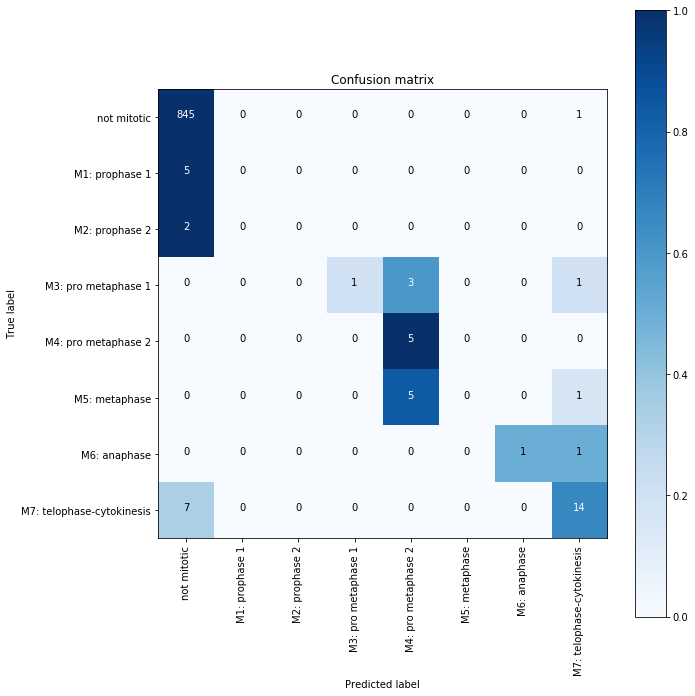

In [12]:
pred_classes_test = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_test)])
modelAnalysis(y_test, pred_classes_test)

## Use all features

### Load data

In [13]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

df = df.dropna(subset=['MitosisLabel'])

print('Release', df.query('MitoticHandoff == "Release"').shape)
print('Ongoing', df.query('MitoticHandoff == "Ongoing"').shape)
print('Microscopy', df.query('MitoticHandoff == "Microscopy"').shape)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Release (4457, 2531)
Ongoing (2349, 2531)
Microscopy (323, 2531)


In [14]:
target_col = 'MitosisLabel'
feature_cols = df.columns[df.columns.str.contains(pat = 'feat_')]

df = df.fillna(0)
df = df[df[target_col] >= 0]
df_release = df.query('MitoticHandoff == "Release"')
df_ongoing = df.query('MitoticHandoff == "Ongoing" | MitoticHandoff == "Microscopy"')

### Train and test set -- use to find a good model

In [15]:
X_train_test, y_train_test = make_X_y_from_df(df_release,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_train_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([4207,   31,   22,   16,   39,   23,   27,   92]))

### Validation set -- held out until after model is locked down

In [16]:
X_validation, y_validation = make_X_y_from_df(df_ongoing,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_validation, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2324,   15,    8,   30,   59,   30,   44,  162]))

### Split train and test apart

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test,
                                                    test_size=0.2,
                                                    random_state=42)

unique_classes, class_counts = np.unique(y_train_test, return_counts=True)
class_weights = class_counts/np.sum(class_counts)
class_weights

lgb_train = lgb.Dataset(X_train, y_train,
                        weight=np.array([class_weights[int(i)] for i in y_train]),
                        free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train,
                        weight=np.array([class_weights[int(i)] for i in y_test]),
                       free_raw_data=False)

### Train the model

In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(unique_classes),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 100
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_test,
                num_boost_round=1000,
                verbose_eval=100,
                early_stopping_rounds=5)

Training until validation scores don't improve for 5 rounds.
[100]	valid_0's multi_logloss: 0.573604
[200]	valid_0's multi_logloss: 0.205845
[300]	valid_0's multi_logloss: 0.0781858
[400]	valid_0's multi_logloss: 0.0317279
[500]	valid_0's multi_logloss: 0.0148955
[600]	valid_0's multi_logloss: 0.00855948
[700]	valid_0's multi_logloss: 0.00590531
[800]	valid_0's multi_logloss: 0.0051139
[900]	valid_0's multi_logloss: 0.00408914
Early stopping, best iteration is:
[902]	valid_0's multi_logloss: 0.00408097


### Training performance on  old data

                           precision    recall  f1-score   support

              not mitotic       1.00      1.00      1.00      3361
           M1: prophase 1       1.00      0.92      0.96        26
           M2: prophase 2       1.00      0.95      0.97        20
      M3: pro metaphase 1       1.00      1.00      1.00        11
      M4: pro metaphase 2       1.00      1.00      1.00        34
            M5: metaphase       1.00      1.00      1.00        17
             M6: anaphase       1.00      1.00      1.00        25
M7: telophase-cytokinesis       1.00      1.00      1.00        71

              avg / total       1.00      1.00      1.00      3565

accuracy 0.999158485273


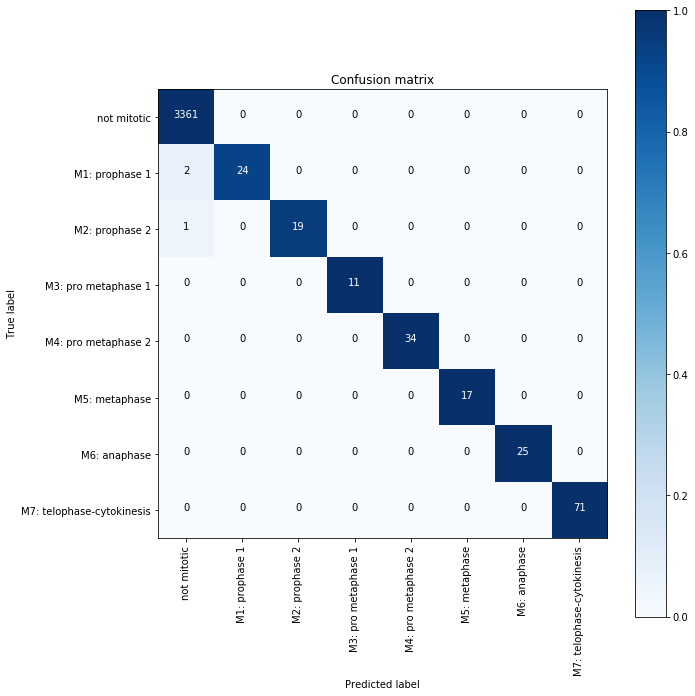

In [19]:
pred_classes_train = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_train)])
modelAnalysis(y_train, pred_classes_train)

### Testing performance on  old data

                           precision    recall  f1-score   support

              not mitotic       0.99      1.00      0.99       846
           M1: prophase 1       0.00      0.00      0.00         5
           M2: prophase 2       0.00      0.00      0.00         2
      M3: pro metaphase 1       1.00      0.40      0.57         5
      M4: pro metaphase 2       0.50      0.80      0.62         5
            M5: metaphase       0.67      0.33      0.44         6
             M6: anaphase       1.00      0.50      0.67         2
M7: telophase-cytokinesis       0.75      0.71      0.73        21

              avg / total       0.97      0.97      0.97       892

accuracy 0.973094170404


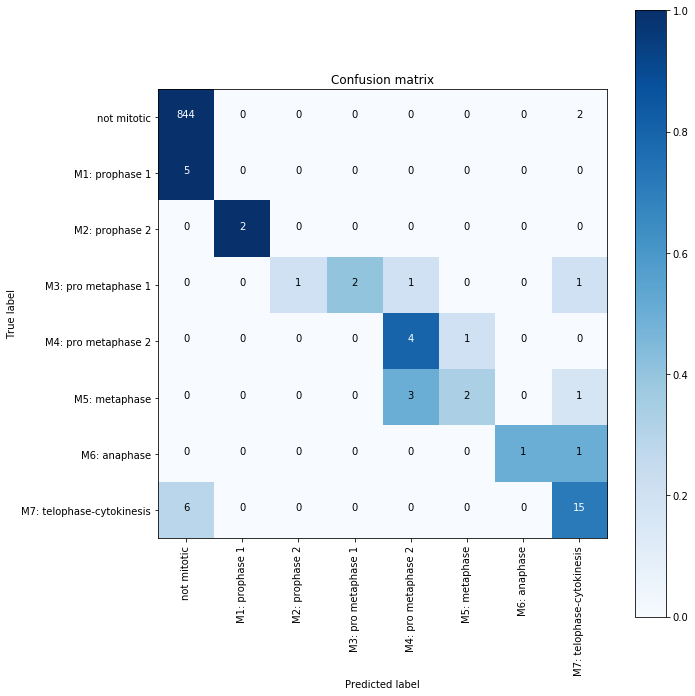

In [20]:
pred_classes_test = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_test)])
modelAnalysis(y_test, pred_classes_test)

### Validation performance on new held-out data

                           precision    recall  f1-score   support

              not mitotic       0.97      1.00      0.98      2324
           M1: prophase 1       1.00      0.07      0.12        15
           M2: prophase 2       1.00      0.75      0.86         8
      M3: pro metaphase 1       0.60      0.20      0.30        30
      M4: pro metaphase 2       0.53      0.53      0.53        59
            M5: metaphase       0.52      0.47      0.49        30
             M6: anaphase       0.56      0.20      0.30        44
M7: telophase-cytokinesis       0.69      0.66      0.68       162

              avg / total       0.93      0.93      0.93      2672

accuracy 0.934505988024


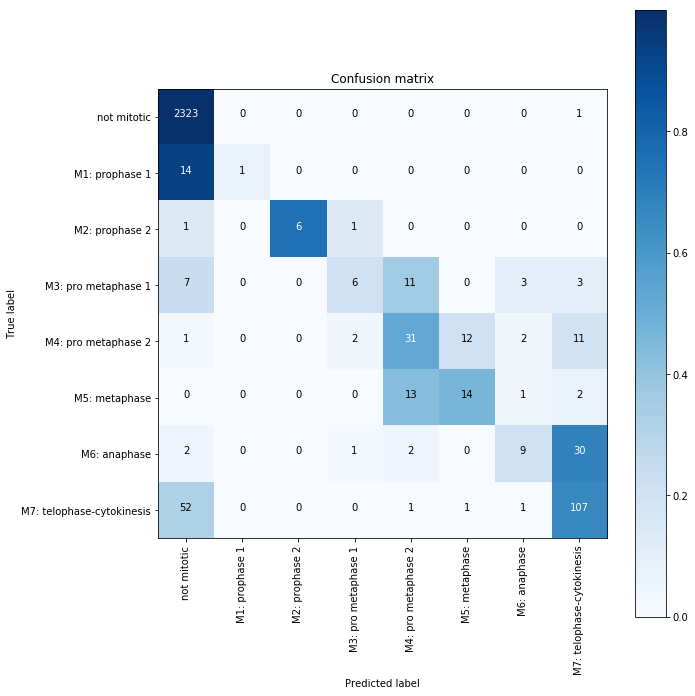

In [21]:
pred_classes_valid = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_validation)])
modelAnalysis(y_validation, pred_classes_valid)

## Predict on unannotated cells

### Load data

In [22]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

df_unknown = df[pd.isnull(df['MitosisLabel'])]
df_unknown.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(14839, 2531)

### Perform predictions

In [23]:
X_unknown = df_unknown[feature_cols].values
pred_classes_unknown = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_unknown)])
np.unique(pred_classes_unknown, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([14072,     5,    32,    26,   198,    40,    23,   443]))

### Merge in predictions

In [24]:
# pick out some minimally useful columns to save
df_unknown_key_and_ims = df_unknown[['inputFolder',
                                     'inputFilename',
                                     'outputThisCellIndex',
                                     'save_flat_reg_path',
                                     'save_flat_proj_reg_path']]

# add in predicted mitotic class
df_unknown_key_and_ims['predicted_class'] = pd.Series(pred_classes_unknown, index=df_unknown_key_and_ims.index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Visually inspect predictions

#### Some images aren't actrually there!  this needs to get fixed!

In [25]:
df_unknown_key_and_ims.shape

(14839, 6)

In [26]:
# find files with nonzero size

im_dir = '/home/jovyan/aics/modeling/gregj/results/ipp_17_10_31'

df_unknown_key_and_ims['file_size'] = pd.Series(np.zeros(len(df_unknown_key_and_ims)))
for index, row in tqdm_notebook(df_unknown_key_and_ims.iterrows(),
                                total=len(df_unknown_key_and_ims),
                                desc='scanning files'):

    # for each file listed
    full_file_path = os.path.join(im_dir, df_unknown_key_and_ims.loc[index, 'save_flat_proj_reg_path'])

    # record the file size if it exists else recors zero
    df_unknown_key_and_ims.loc[index, 'file_size'] = os.path.getsize(full_file_path) if \
                                                         os.path.isfile(full_file_path) else \
                                                         np.NaN

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


HBox(children=(IntProgress(value=0, description='scanning files', max=14839), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Compare all un-annotated predictions to predictions on un-annoted cells where we actually have the pngs

In [27]:
np.unique(df_unknown_key_and_ims['predicted_class'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([14072,     5,    32,    26,   198,    40,    23,   443]))

In [28]:
df_unknown_key_and_ims_present = df_unknown_key_and_ims.dropna(subset=['file_size'])
np.unique(df_unknown_key_and_ims_present['predicted_class'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([11701,     4,    27,    18,   163,    35,    21,   259]))

### Inspect predictions visually on samples

phase 0:


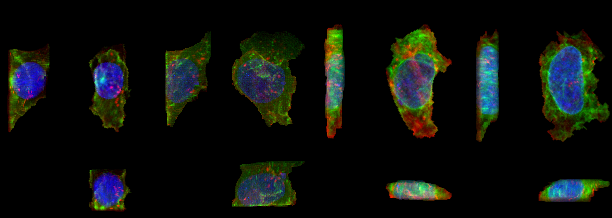

phase 1:


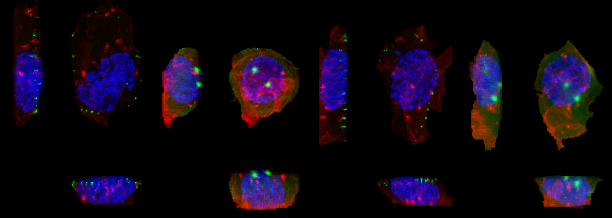

phase 2:


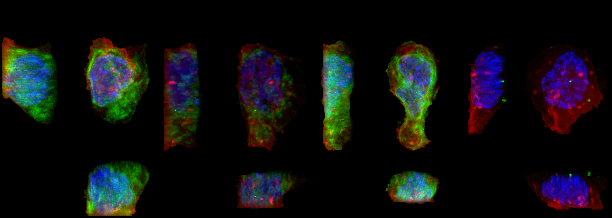

phase 3:


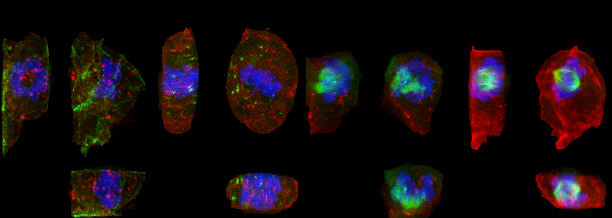

phase 4:


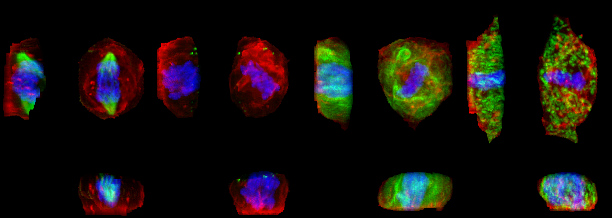

phase 5:


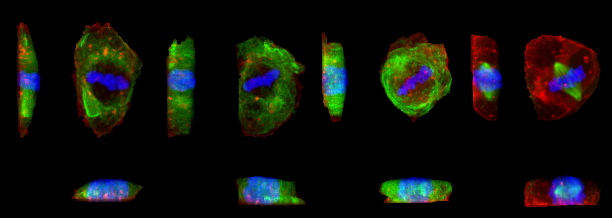

phase 6:


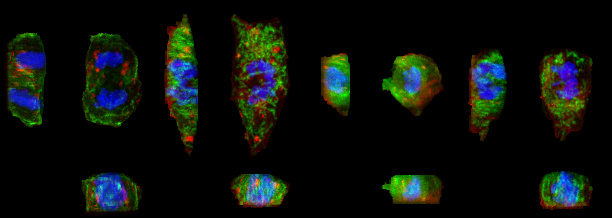

phase 7:


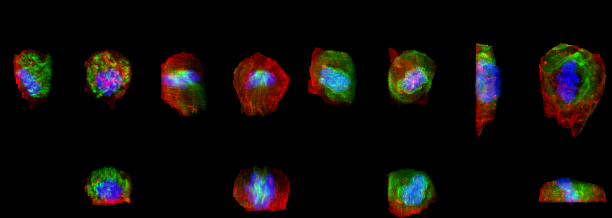

In [29]:
im_dir = '/home/jovyan/aics/modeling/gregj/results/ipp_17_10_31'
img_dims = (218,153,3)
N_samples = 4
image_stacks = {}

for c in np.unique(df_unknown_key_and_ims_present['predicted_class']):
    query_string = 'predicted_class == {}'.format(c)
    pred_c_samples = df_unknown_key_and_ims_present.query(query_string)["save_flat_proj_reg_path"].sample(N_samples).values
    
    image_stack = np.zeros(shape=(img_dims[0],0,img_dims[2]), dtype=np.uint8)
    for i,img_loc in enumerate(pred_c_samples):
        img_path = os.path.join(im_dir,img_loc)
        this_img = np.array(Image.open(img_path))
        this_img = this_img[:img_dims[0],:img_dims[1],:img_dims[2]]
        image_stack = np.hstack([image_stack, this_img])
    image_stacks[c] = image_stack
    
for k,v in image_stacks.items():
    image = Image.fromarray(v)
    print('phase {}:'.format(k))
    display(image)

#### Save prediction csv

In [30]:
df_unknown_key_and_ims.to_csv('mitotic_predictions_gbdts.csv', index=False)